<a href="https://colab.research.google.com/github/AJoshEdwards/ChicagoTaxi/blob/main/Chicago_Taxi_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1>Chicago Taxi Analysis</h1>

## <h2>Introduction</h2>

<b>"How can a company increase their total number of taxi trips?"</b><br>

In this notebook I'll look to explore the public bigquery dataset for Chicago Taxi Trips 2022 and look to answer the question "How can a company increase their total number of taxi trips?"<br> Having briefly looked at the dataset I have a few initial ideas to investigate:<br>

*   Does the amount of Taxis a company owns affect the amount of Trips they can do?
*   Is there a Community Area that the majority of Trips take place in?
*   How does the amount of trips change throughout the year?
*   Does the Day of the Week affect the amount of trips? What about time of day?
*   How does the Duration of a Trip affect the amount of Trips a Taxi Company can do?

<b>Methodology</b>

1.   Import the relevant libraries and successfully connect to the dataset
2.   Clean and transform the data as appropriate
3.   Apply different exploratory data analysis techniques to understand the data and explore my initial ideas, producing visualisations using plotly express
4.   Answer the question "How can a company increase their total number of taxi trips?"

### <h3>Import Libraries</h3>

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from IPython.display import Markdown
import plotly
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.io as pio
from plotly.subplots import make_subplots
from google.colab import data_table
png_renderer = pio.renderers["png"]
png_renderer.width = 2000
png_renderer.height = 700
pio.renderers.default = "png"
data_table.enable_dataframe_formatter()

### <h3>Create and Test Connection</h3>

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.cloud import bigquery
client = bigquery.Client(project='chicagotaxi-380117')
#sql query for 2022 data
sql = """
SELECT *
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE FORMAT_TIMESTAMP("%Y", trip_start_timestamp) = '2022';
"""
#create dataframe from query outputs
df = client.query(sql).to_dataframe()
#display first rows of dataframe to confirm loaded correctly
df.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,13b3205d0020a02bdfce2c2d02be4dc7a22211ef,fdb16324f07e66dd7338161569ae6991f89e38884bac4a...,2022-09-25 09:00:00+00:00,2022-09-25 09:15:00+00:00,531,2.28,17031081600,17031330100,8,33,...,1.0,12.75,Credit Card,Sun Taxi,41.892073,-87.628874,POINT (-87.6288741572 41.8920726347),41.859350,-87.617358,POINT (-87.6173580061 41.859349715)
1,18bb8a9f7f2875507fdab5d25a1dcfc112c14eae,3fcd4c899db0f7f4d7dbd3b4b6370dcaa4b888f57db00f...,2022-09-12 13:00:00+00:00,2022-09-12 13:30:00+00:00,1712,7.19,<NA>,<NA>,72,46,...,0.0,23.00,Prcard,Flash Cab,41.713149,-87.675075,POINT (-87.6750753124 41.713148612),41.741243,-87.551428,POINT (-87.551428197 41.7412427285)
2,1aa929d64a1c659c79ca5caa3462a18e498cf29e,1964b524630688b3ead3b4b75a710036898498ce0de967...,2022-10-11 23:45:00+00:00,2022-10-12 00:00:00+00:00,480,2.10,<NA>,<NA>,16,14,...,0.0,9.25,Cash,"Taxicab Insurance Agency, LLC",41.953582,-87.723452,POINT (-87.7234523905 41.9535821253),41.968069,-87.721559,POINT (-87.7215590627 41.968069)
3,6d1a7b0841071c817ae63950b7e298fe60c7822e,3ab5300e6e7ee5a0f90b99ed2b65f3c37a964694114280...,2022-01-05 07:45:00+00:00,2022-01-05 08:15:00+00:00,1384,10.83,<NA>,<NA>,44,28,...,0.0,29.50,Prcard,City Service,41.740206,-87.615970,POINT (-87.6159695226 41.7402057565),41.874005,-87.663518,POINT (-87.6635175498 41.874005383)
4,797a2a5ffed5f2764e78dad8feccaeba0f4eea66,f6e15e1e93c7648c1ffb637834e78905aca64ba09e2f46...,2022-01-25 13:00:00+00:00,2022-01-25 13:30:00+00:00,1846,7.24,<NA>,<NA>,13,4,...,0.0,22.50,Prcard,Flash Cab,41.983636,-87.723583,POINT (-87.7235831853 41.9836363072),41.975171,-87.687516,POINT (-87.6875155152 41.9751709433)


With the connection tested and data loading, we can explore the data and decide what kind of pre-processing will be needed.

## <h2>Data Cleaning</h2>

In [4]:
#How many rows and columns are in the dataset?
rows_count = len(df.index)
df.shape

(6382071, 23)

In [33]:
#What are the column types stored as?
df.dtypes

unique_key                             object
taxi_id                                object
trip_start_timestamp      datetime64[ns, UTC]
trip_end_timestamp        datetime64[ns, UTC]
trip_seconds                            Int64
trip_miles                            float64
pickup_census_tract                     Int64
dropoff_census_tract                    Int64
pickup_community_area                   Int64
dropoff_community_area                  Int64
fare                                  float64
tips                                  float64
tolls                                 float64
extras                                float64
trip_total                            float64
payment_type                           object
company                                object
pickup_latitude                       float64
pickup_longitude                      float64
pickup_location                        object
dropoff_latitude                      float64
dropoff_longitude                 

In [34]:
#How many null values exist?
df.isnull().sum()

unique_key                      0
taxi_id                         0
trip_start_timestamp            0
trip_end_timestamp            211
trip_seconds                 1464
trip_miles                     56
pickup_census_tract       3758241
dropoff_census_tract      3706741
pickup_community_area      513501
dropoff_community_area     633332
fare                         3533
tips                         3533
tolls                        3533
extras                       3533
trip_total                   3533
payment_type                    0
company                         0
pickup_latitude            511199
pickup_longitude           511199
pickup_location            511199
dropoff_latitude           597579
dropoff_longitude          597579
dropoff_location           597579
dtype: int64

In [35]:
#@title Initial Data Overview
display(Markdown(f"###The dataset consists of **{rows_count:,}** rows and 23 columns for 2022. There are missing values in 18 out of the 23 columns, with pickup_census_tract and dropoff_census_tract both containing **over 50%** missing values."))
display(Markdown(f"###<li>Firstly I will remove both of these columns from the dataset as well as only keeping in the pickup_community_area and dropoff_community_area for location columns for any location analysis.</li>"))
display(Markdown(f"###<li>Secondly I will remove the 3533 null rows from the fare column as this means the fare has not been recorded.</li>"))
display(Markdown(f"###<li>Finally I will remove the rows where trip seconds = null as well as trip_miles = null (probable data errors).</li>"))

###The dataset consists of **6,382,071** rows and 23 columns for 2022. There are missing values in 18 out of the 23 columns, with pickup_census_tract and dropoff_census_tract both containing **over 50%** missing values.

###<li>Firstly I will remove both of these columns from the dataset as well as only keeping in the pickup_community_area and dropoff_community_area for location columns for any location analysis.</li>

###<li>Secondly I will remove the 3533 null rows from the fare column as this means the fare has not been recorded.</li>

###<li>Finally I will remove the rows where trip seconds = null as well as trip_miles = null (probable data errors).</li>

In [36]:
#remove unnecessary columns
df_clean = df.drop(columns=['pickup_census_tract', 'dropoff_census_tract','pickup_latitude','pickup_longitude','pickup_location','dropoff_latitude','dropoff_longitude','dropoff_location'])
#drop rows where the columns data is missing
df_clean = df_clean[df_clean['fare'].notna()]
df_clean = df_clean[df_clean['trip_seconds'].notna()]
df_clean = df_clean[df_clean['trip_miles'].notna()]
df_clean = df_clean[df_clean['pickup_community_area'].notna()]
df_clean = df_clean[df_clean['dropoff_community_area'].notna()]
#recheck the now cleaned dataframe
df_clean.isnull().sum()

unique_key                0
taxi_id                   0
trip_start_timestamp      0
trip_end_timestamp        0
trip_seconds              0
trip_miles                0
pickup_community_area     0
dropoff_community_area    0
fare                      0
tips                      0
tolls                     0
extras                    0
trip_total                0
payment_type              0
company                   0
dtype: int64

In [37]:
#How many rows and columns now exist in the cleaned dataset?
rows_count_clean = len(df_clean.index)
rows_diff = rows_count - rows_count_clean
#How many companies are there?
company_count = df_clean['company'].nunique()
#How many taxis are there?
taxi_count = df_clean['taxi_id'].nunique()
#How many pickup community areas are there?
ca_count = df_clean['pickup_community_area'].nunique()
#How many trip miles were there in total?
miles_sum = df_clean['trip_miles'].sum().astype(int)
#How many days were there in total?
dur_sum = df_clean['trip_seconds'].sum()/86400
dur_sum = dur_sum.astype(int)
#How many columns and rows are there?
df_clean.shape

(5467826, 15)

In [38]:
#@title Cleaned Data Overview
display(Markdown(f"###There are now **{rows_count_clean:,}** rows, down **{rows_diff:,}** from the initial dataset with each row representing a single trip. There are {company_count} companies with {taxi_count:,} taxis as well as {ca_count} pick up community areas."))
display(Markdown(f"###In total {miles_sum:,} miles were covered as well as {dur_sum:,} days spent by people in a taxi."))
display(Markdown(f"###It's worth noting that removing the null rows from the fare column also removed the null rows from the tips, tools, extras and trip_total columns as well."))

###There are now **5,467,826** rows, down **914,245** from the initial dataset with each row representing a single trip. There are 35 companies with 2,886 taxis as well as 77 pick up community areas.

###In total 29,352,022 miles were covered as well as 71,224 days spent by people in a taxi.

###It's worth noting that removing the null rows from the fare column also removed the null rows from the tips, tools, extras and trip_total columns as well.

## <h2>How can a company increase their total number of taxi trips?</h2>

To answer the question <b>"How can a company increase their total number of taxi trips?"</b> I have a few initial ideas.
*   Does the amount of Taxis a company owns affect the amount of Trips they can do?
*   Is there a Community Area that the majority of Trips take place in?
*   How does the amount of trips change throughout the year?
*   Does the Day of the Week affect the amount of trips? What about time of day?
*   How does the Duration of a Trip affect the amount of Trips a Taxi Company can do?

Throughout my analysis, for efficiency and consistency, I will use a random sample of 100,000 datapoints from the clean dataset, generated at the start of the analysis. As this random sample can change whenever the initial cell is run I'll generate variables within my code to be used in my analysis paragraphs, that way the analysis is refreshed and up to date whenever the code cell is run.

### **<h3>Number of Taxis vs Number of Trips</h3>**

Does the amount of Taxis a company owns affect the amount of Trips they can do?<br><br>
Intuitively you'd expect that a company with a larger fleet of taxis are able to provide more trips over the course of a year.<br> To investigate this I will group the dataset by company, and aggregate the unique_key and taxi_id column to calculate the number of trips and number of taxis per company. I will then plot this data with a trendline to see the correlation.

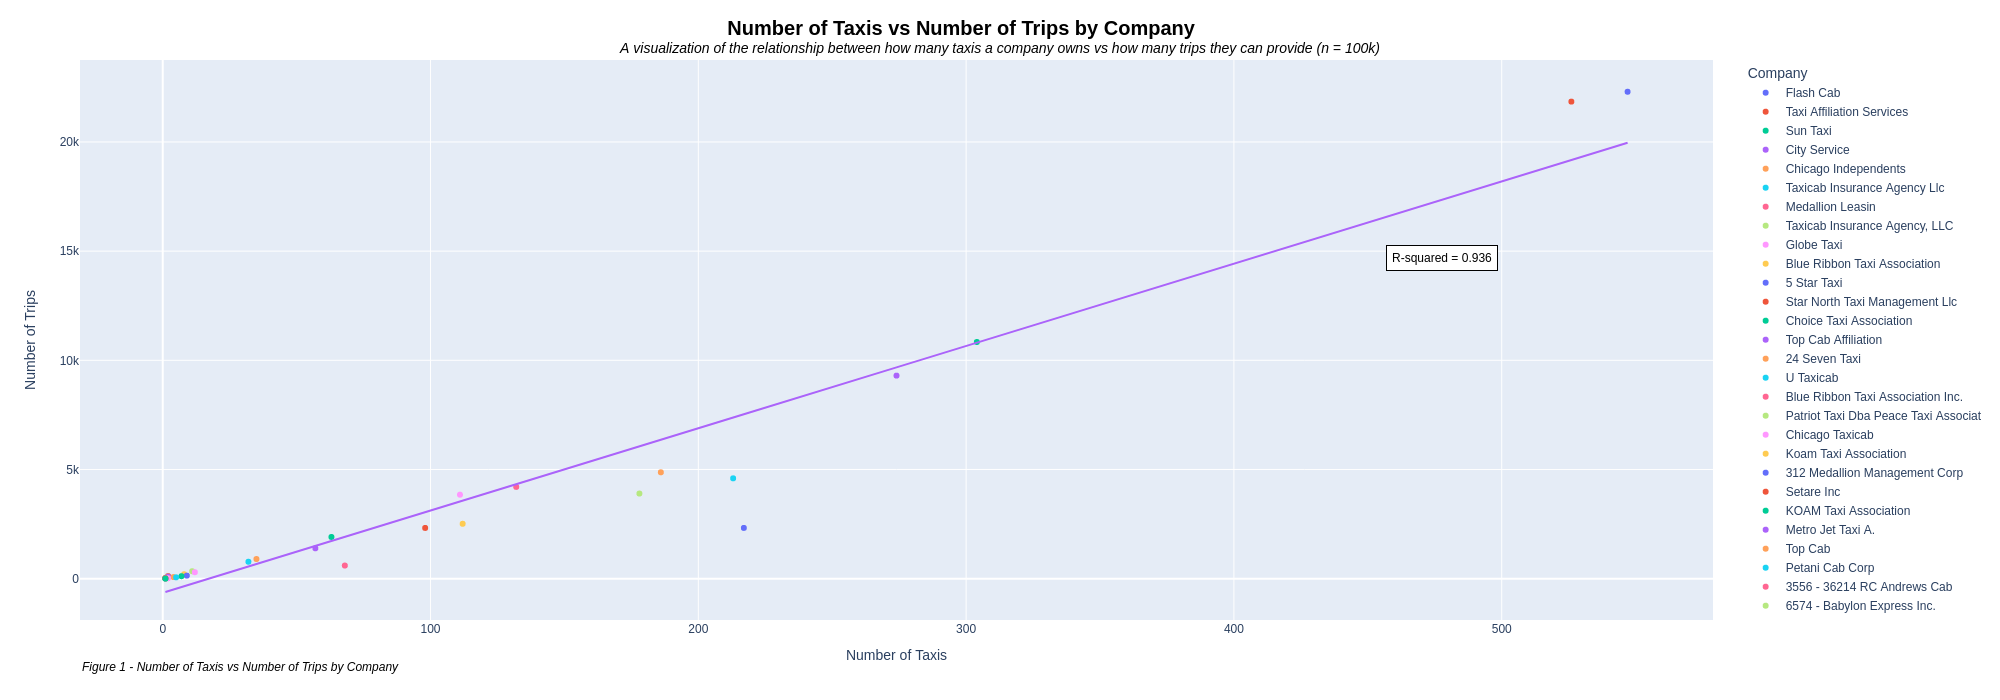

,Company,Number of Taxis,Number of Trips
0,Flash Cab,547,22299
1,Taxi Affiliation Services,526,21847
2,Sun Taxi,304,10839
3,City Service,274,9299
4,Chicago Independents,186,4872
5,Taxicab Insurance Agency Llc,213,4596
6,Medallion Leasin,132,4203
7,"Taxicab Insurance Agency, LLC",178,3899
8,Globe Taxi,111,3845
9,Blue Ribbon Taxi Association,112,2514


In [39]:
#@title Number of Taxis vs Number of Trips by Company Code
#Create a random sample of 100k datapoints to use for visualisations
df_random = df_clean.sample(n=100000)
#Create a company dataframe with a distinct count of taxi_id and unique_key as aggregations.
#Rename columns for visualisation
df_company = df_random.groupby(['company'])[['taxi_id','unique_key']].nunique().reset_index().rename(columns={'company':'Company','unique_key':'Number of Trips','taxi_id':'Number of Taxis'})
#Resort the dataframe by Number of Trips
df_company = df_company.sort_values(by=['Number of Trips'],ascending=False).reset_index(drop=True)
#Create scatter plot with trendline
fig = px.scatter(df_company,x="Number of Taxis",y="Number of Trips", trendline="ols",trendline_scope="overall", color="Company",width=2000,height=700)
fig.update_layout(title=dict(
        text='<b>Number of Taxis vs Number of Trips by Company</b>\
              <br><i><sup>A visualization of the relationship between how many taxis a company owns vs how many trips they can provide (n = 100k)</sup></i>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Arial",
            size=20,
            color='#000000'
        )))
# Add explanation of line:
model = px.get_trendline_results(fig)
rsq = model.iloc[0]["px_fit_results"].rsquared
fig.add_annotation(x=.8,
                    y=0.67,
                    text="R-squared" + ' = ' + str(round(rsq, 3)),
                    textangle=0,
                    xanchor='left',
                    xref="paper",
                    yref="paper",
                    font_color='black',
                    bordercolor='black',
                    borderpad=5,
                    showarrow=False,
                    bgcolor='white',
                    )
# Add figure annotation:
fig.add_annotation(x=0,
                    y=-0.1,
                    showarrow=False,
                    text="<i>Figure 1 - Number of Taxis vs Number of Trips by Company</i>",
                    textangle=0,
                    xanchor='left',
                    xref="paper",
                    yref="paper",
                    font_color='#000000')



#Display scatter plot
fig.show()
#Variables for the analysis paragraph
top1_company = df_company['Company'].iloc[0]
top1_taxis = df_company['Number of Taxis'].iloc[0]
top1_trips = df_company['Number of Trips'].iloc[0]
top2_company = df_company['Company'].iloc[1]
top2_taxis = df_company['Number of Taxis'].iloc[1]
top2_trips = df_company['Number of Trips'].iloc[1]
r2 = px.get_trendline_results(fig).px_fit_results.iloc[0].rsquared
r2 = round(r2,3)

#Display top 10 companies by number of trips
data_table.DataTable(df_company, include_index=False, num_rows_per_page=10)

In [40]:
#@title Analysis
display(Markdown(f"###Figure 1 shows a comparison of Number of Taxis vs Number of Trips by Company."))
display(Markdown(f"###There is a strong positive correlation **(R²={r2})** between number of taxis and number of trips indicating the more taxis a company has the more trips that they can provide. This makes sense intuitively, but it's good to be backed up by the data."))
display(Markdown(f"###Noticeable highlights in this sample are **{top1_company}** and **{top2_company}** in the top right at **{top1_taxis}** taxis with **{top1_trips:,}** trips **({top1_company})** and **{top2_taxis}** taxis with **{top2_trips:,}** trips **({top2_company})**."))
display(Markdown(f"###As expected the more taxis a company owns the more trips they can provide, however there is a small group of companies around the 200 taxis mark underneath the trendline with fewer number of trips than expected. This suggests there is more to the data than simply more taxis = more trips."))

###Figure 1 shows a comparison of Number of Taxis vs Number of Trips by Company.

###There is a strong positive correlation **(R²=0.936)** between number of taxis and number of trips indicating the more taxis a company has the more trips that they can provide. This makes sense intuitively, but it's good to be backed up by the data.

###Noticeable highlights in this sample are **Flash Cab** and **Taxi Affiliation Services** in the top right at **547** taxis with **22,299** trips **(Flash Cab)** and **526** taxis with **21,847** trips **(Taxi Affiliation Services)**.

###As expected the more taxis a company owns the more trips they can provide, however there is a small group of companies around the 200 taxis mark underneath the trendline with fewer number of trips than expected. This suggests there is more to the data than simply more taxis = more trips.

### **<h3>Pickup Community Area</h3>**

Is there a Community Area that the majority of Trips take place in? <br><br>
Using the Pickup Community Area column we can try to understand if specific regions of Chicago are more popular with taxi usage than others.
To do this I will group the random dataset by the pickup_community_area column and aggregate the unique_key column to calculate the number of trips by area. As there are 77 community areas it would be worth showing the cumulative percentage of the community areas sorted by number of trips as I suspect a lot of the community areas will have very few trips recorded against them.

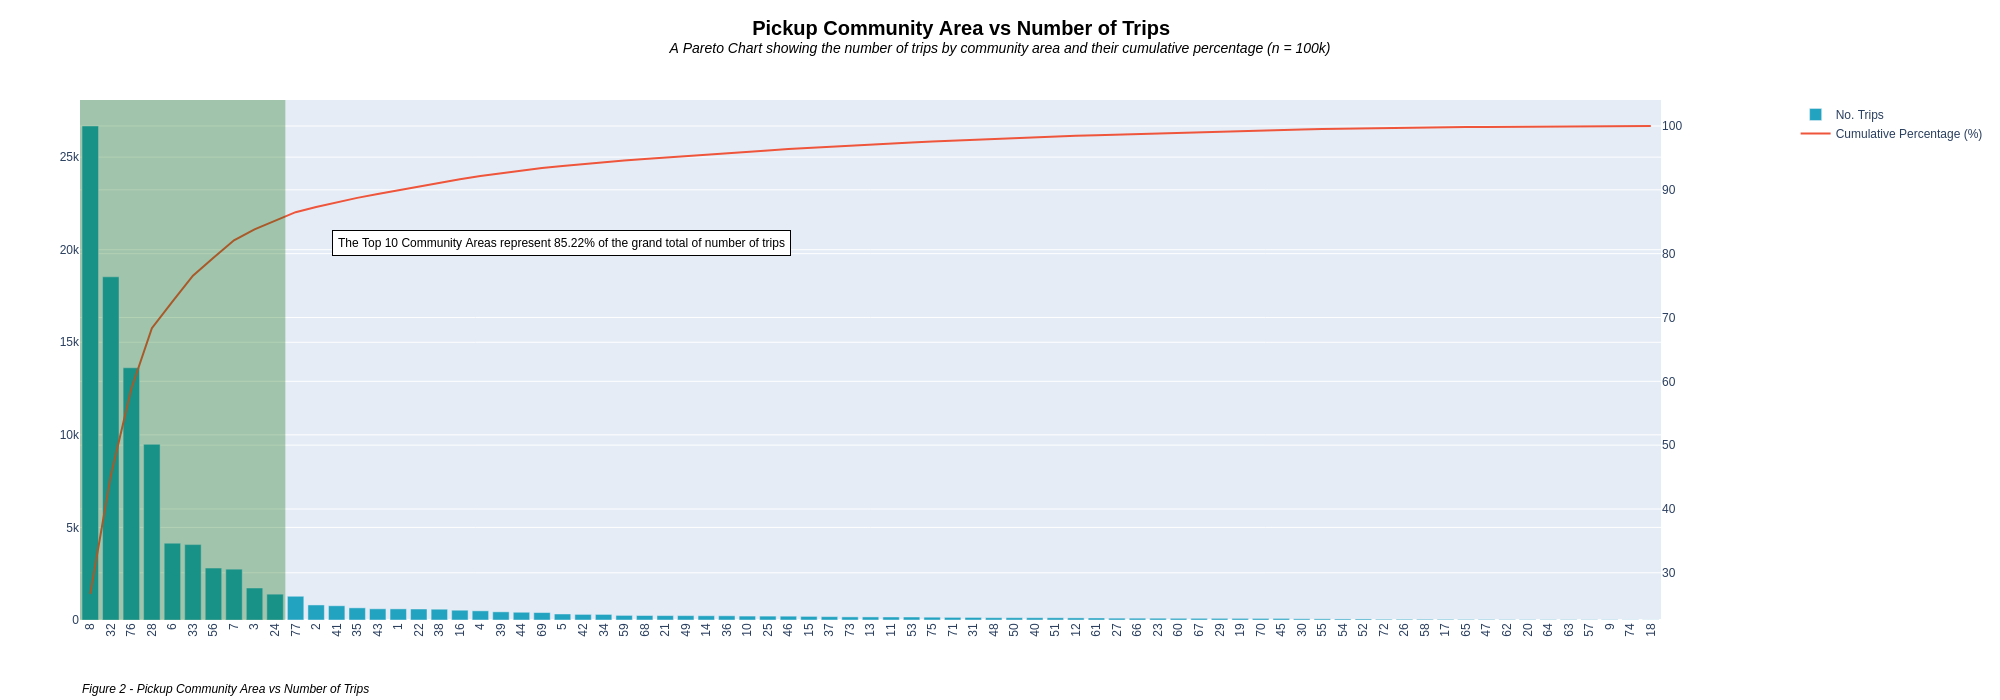

,Pickup Community Area,Number of Trips,Cumulative Sum,Cumulative Percentage (%)
0,8,26681,26681,26.68
1,32,18534,45215,45.22
2,76,13621,58836,58.84
3,28,9488,68324,68.32
4,6,4149,72473,72.47
...,...,...,...,...
72,63,21,99947,99.95
73,57,18,99965,99.96
74,9,17,99982,99.98
75,74,11,99993,99.99


In [41]:
#@title Pickup Community Area vs Number of Trips Code
#As the Pickup Community Area is stored as a float (even though they are specific areas) I will change the data type to a string for easy use within the visualisation
df_random['pickup_community_area'] = df_random['pickup_community_area'].astype(str)
#Create pickup dataframe using the random sample dataframe as shown previously. Rename columns for the visualisation
df_pickup = df_random.groupby(['pickup_community_area'])[['unique_key']].nunique().reset_index().rename(columns={'pickup_community_area':'Pickup Community Area','unique_key':'Number of Trips'})
#Sort dataframe by Number of Trips
df_pickup = df_pickup.sort_values(by=['Number of Trips'],ascending=False).reset_index(drop=True)
#Add in a cumulative sum of number of trips column
df_pickup['Cumulative Sum'] = df_pickup['Number of Trips'].cumsum()
#Add in a cumulative percentage of the number of trips column divide by the total number of trips within the dataframe for the pareto chart
df_pickup['Cumulative Percentage (%)'] = 100*df_pickup['Cumulative Sum']/df_pickup['Number of Trips'].sum()
#Round the cumulative percentage column to show 2 decimal places
df_pickup = df_pickup.round({'Cumulative Percentage (%)':2})

#Create bar chart of number of trips by community area
trace1 = go.Bar(
    x=df_pickup['Pickup Community Area'],
    y=df_pickup['Number of Trips'],
    name = 'No. Trips',
    marker=dict(
        color='rgb(34,163,192)'
               )
)
#Create line chart of the cumulative percentage by community area for the 2nd axis
trace2 = go.Scatter(
    x=df_pickup['Pickup Community Area'],
    y=df_pickup['Cumulative Percentage (%)'],
    name='Cumulative Percentage (%)',
    yaxis='y2'

)
#Combine both charts
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig.update_layout(
    title=dict(
        text='<b>Pickup Community Area vs Number of Trips</b>\
              <br><i><sup>A Pareto Chart showing the number of trips by community area and their cumulative percentage (n = 100k)</sup></i>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Arial",
            size=20,
            color='#000000'
        ))
        ,xaxis=dict(
      tickangle=-90
    ))
top10 = df_pickup['Cumulative Percentage (%)'].iloc[9]
# Add highlight box:
fig.add_vrect(x0="-0.5",
               x1="9.5",
               fillcolor="darkgreen",
               opacity=0.3,
               line_width=0)

# Add explanation of line:
fig.add_annotation(x=.15,
                    y=0.75,
                    text="The Top 10 Community Areas represent " + str(round(top10, 3)) + "% of the grand total of number of trips",
                    textangle=0,
                    xanchor='left',
                    xref="paper",
                    yref="paper",
                    font_color='black',
                    bordercolor='black',
                    borderpad=5,
                    showarrow=False,
                    bgcolor='white',
                    )

# Add figure annotation:
fig.add_annotation(x=0,
                    y=-0.15,
                    showarrow=False,
                    text="<i>Figure 2 - Pickup Community Area vs Number of Trips</i>",
                    textangle=0,
                    xanchor='left',
                    xref="paper",
                    yref="paper",
                    font_color='#000000')

#Show the combined charts
fig.show()
#variables for the analysis paragraph
top10 = df_pickup['Cumulative Percentage (%)'].iloc[9]
top3 = df_pickup['Cumulative Percentage (%)'].iloc[2]

#Show the dataframe
data_table.DataTable(df_pickup, include_index=False, num_rows_per_page=10)

In [42]:
#@title Analysis
display(Markdown(f"###Figure 2 shows total trips by pickup community area as well as each community area's percentage of the grand total. I've chosen to show cumulative percentage on the second axis and as suspected there are a large amount of community areas with very little taxi usage."))
display(Markdown(f"###The top 10 community areas account for over **{top10}%** of the total trips, with Community Areas 8, 32 and 76 accounting for **{top3}%** alone. These areas should be focused, ensuring taxi availability to increase number of trips."))

###Figure 2 shows total trips by pickup community area as well as each community area's percentage of the grand total. I've chosen to show cumulative percentage on the second axis and as suspected there are a large amount of community areas with very little taxi usage.

###The top 10 community areas account for over **85.22%** of the total trips, with Community Areas 8, 32 and 76 accounting for **58.84%** alone. These areas should be focused, ensuring taxi availability to increase number of trips.

#### **<h4>Average Fare</h4>**

As an aside I'm curious to see what the breakdown of the top 5 community areas by total trips looks like when including average fare, average length of trip and average trip duration.
To analyse this I will repeat the steps above but instead of cumulative columns I will aggregate the mean of the fare, trip_miles and trip_seconds columns in the dataset.  

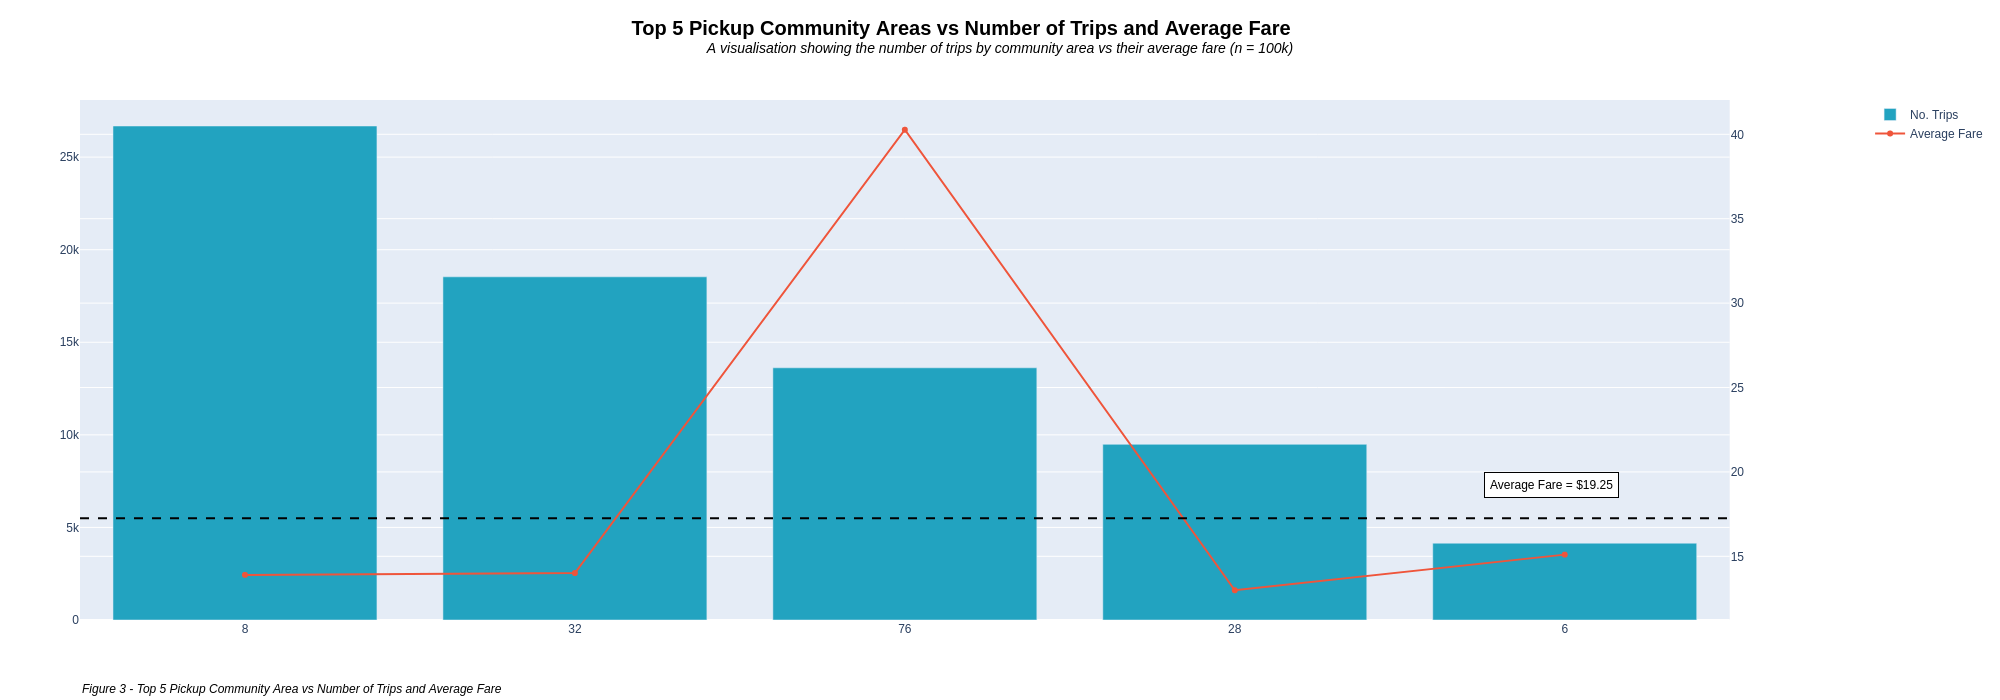

,Pickup Community Area,Number of Trips,Average Fare,Average Distance,Average Duration (Minutes)
0,8,26681,13.90,3.19,13
1,32,18534,14.01,3.53,13
2,76,13621,40.27,13.63,36
3,28,9488,12.99,2.96,13
4,6,4149,15.10,3.49,15


In [43]:
#@title Top 5 Pickup Community Areas vs Number of Trips and Average Fare Code
#Create new dataset for new analysis
df_pickup_fare = df_random
#Group by pickup community area and aggregate the number of trips and average fare
df_pickup_fare = df_random.groupby(['pickup_community_area']).agg({'unique_key':'nunique', 'fare':'mean','trip_miles':'mean','trip_seconds':'mean'})
#Sort the table by number of trips
df_pickup_fare = df_pickup_fare.sort_values(by=['unique_key'],ascending=False).reset_index(drop=False)
#Only keep the top 5 for analysis
df_pickup_fare_5 = df_pickup_fare.head(5)
#Round the fare and miles formatting to 2 decimal places
df_pickup_fare_5 = df_pickup_fare_5.round({'fare':2,'trip_miles':2})
#Convert the seconds column into minutes and format as integers
df_pickup_fare_5['trip_seconds'] = df_pickup_fare_5['trip_seconds'].div(60).round(2).astype(int)
#Rename table headers
df_pickup_fare_5 = df_pickup_fare_5.rename(columns={'pickup_community_area':'Pickup Community Area','unique_key':'Number of Trips','fare':'Average Fare','trip_miles':'Average Distance','trip_seconds':'Average Duration (Minutes)'})

#variables for the analysis paragraph
fare_ca = df_pickup_fare_5.iloc[2]
fare_ca = fare_ca['Average Fare']
bot_fare = df_pickup_fare_5.iloc[4]
bot_fare = bot_fare['Average Fare']

#Create bar chart of number of trips by community area
trace1 = go.Bar(
    x=df_pickup_fare_5['Pickup Community Area'],
    y=df_pickup_fare_5['Number of Trips'],
    name = 'No. Trips',
    marker=dict(
        color='rgb(34,163,192)'
               )
)
#Create line chart of the Average Fare by Pickup Community Area
trace2 = go.Scatter(
    x=df_pickup_fare_5['Pickup Community Area'],
    y=df_pickup_fare_5['Average Fare'],
    name='Average Fare',
    yaxis='y2'
)
#Combine both charts
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig.update_layout(
    title=dict(
        text='<b>Top 5 Pickup Community Areas vs Number of Trips and Average Fare</b>\
              <br><i><sup>A visualisation showing the number of trips by community area vs their average fare (n = 100k)</sup></i>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Arial",
            size=20,
            color='#000000'
        )))

# Add average fare across top 5:
fig.add_hline(y=df_pickup_fare_5['Average Fare'].mean()-2,
              line_dash='dash',
              line_color='black',
              secondary_y=True)

# Add explanation of line:
fig.add_annotation(x=.8,
                    y=df_pickup_fare_5['Average Fare'].mean(),
                    text="Average Fare = $" + str(round(df_pickup_fare_5['Average Fare'].mean(),2)),
                    textangle=0,
                    xanchor='left',
                    xref="paper",
                    font_color='black',
                    bordercolor='black',
                    borderpad=5,
                    showarrow=False,
                    bgcolor='white',
                    yref = "y2"
                    )
# Add figure annotation:
fig.add_annotation(x=0,
                    y=-0.15,
                    showarrow=False,
                    text="<i>Figure 3 - Top 5 Pickup Community Area vs Number of Trips and Average Fare</i>",
                    textangle=0,
                    xanchor='left',
                    xref="paper",
                    yref="paper",
                    font_color='#000000')
#Show the combined charts
fig.show()

#Display the data
data_table.DataTable(df_pickup_fare_5, include_index=False, num_rows_per_page=5)

In [44]:
#@title Analysis
display(Markdown(f"###Interestingly, when comparing the average fare for the top 5 Community Areas there is a big outlier in Community Area 76 at **${fare_ca}**. Whilst this is roughly 3 times the other average fares, it can be explained in part by the community area having 3 times the average distance and over 2 times the duration per trip. This does raise the possibility of focusing on Community Area 76 for higher monetary returns, but other factors such as fuel price should be considered."))
display(Markdown(f"###The rest of the Community Areas are around the 13 dollar mark, with Community Area 33 being slightly higher at ${bot_fare} but again having slightly higher average distances and durations per trip."))

###Interestingly, when comparing the average fare for the top 5 Community Areas there is a big outlier in Community Area 76 at **$40.27**. Whilst this is roughly 3 times the other average fares, it can be explained in part by the community area having 3 times the average distance and over 2 times the duration per trip. This does raise the possibility of focusing on Community Area 76 for higher monetary returns, but other factors such as fuel price should be considered.

###The rest of the Community Areas are around the 13 dollar mark, with Community Area 33 being slightly higher at $15.1 but again having slightly higher average distances and durations per trip.

### **<h3>Number of Trips Over Time</h3>**

How does the amount of trips change throughout the year?<br><br>
Using the trip_start_timestamp column we can create a month column to group the unique_keys by. I'll display this on a line chart along with a dashed line for the average number of trips.

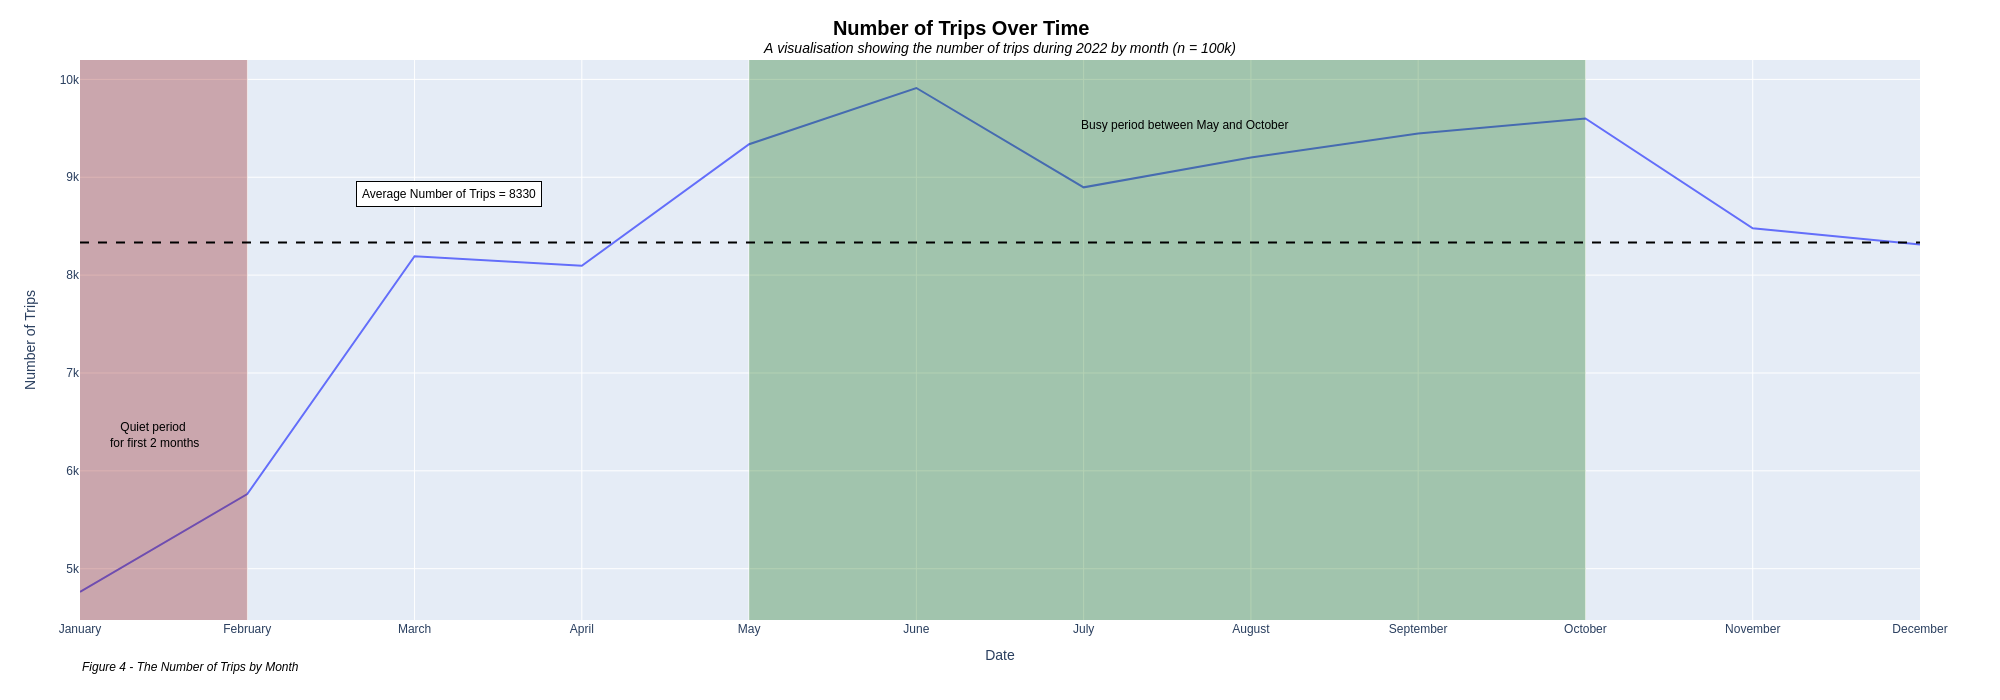

,,Number of Trips
Month,Month Name,
1,January,4762
2,February,5763
3,March,8193
4,April,8096
5,May,9337
6,June,9912
7,July,8897
8,August,9202
9,September,9446


In [45]:
#@title Number of Trips by Month Code
df_month = df_random
#Add a column for the month (integer) based on trip start timestamp column
df_month['Month'] = pd.DatetimeIndex(df_month['trip_start_timestamp']).month
#Add a column for the month name based on the new month column
df_month['Month Name'] = df_month['trip_start_timestamp'].dt.month_name()
#Rename columns for table output
df_month = df_month.rename(columns={'unique_key':'Number of Trips'})
df_month = df_month.groupby(['Month','Month Name']).agg({'Number of Trips':'nunique'})

#Create line chart
fig = px.line(df_month,x=df_month.index.get_level_values(1),y="Number of Trips", height=700)
fig.update_layout(title=dict(
        text='<b>Number of Trips Over Time</b>\
              <br><i><sup>A visualisation showing the number of trips during 2022 by month (n = 100k)</sup></i>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Arial",
            size=20,
            color='#000000'
        )),xaxis_title="Date",
)

# Add highlight box:
fig.add_vrect(x0="0",
               x1="1",
               fillcolor="darkred",
               opacity=0.3,
               line_width=0)
# Add explanation of line:
fig.add_annotation(x=0.015,
                    y=0.3,
                    text="Quiet period <br>for first 2 months",
                    textangle=0,
                    xanchor='left',
                    xref="paper",
                    yref="paper",
                    font_color='black',
                    showarrow=False,
                    )

# Add highlight box:
fig.add_vrect(x0="4",
               x1="9",
               fillcolor="darkgreen",
               opacity=0.3,
               line_width=0)
# Add explanation of line:
fig.add_annotation(x=0.6,
                    y=0.9,
                    text="Busy period between May and October",
                    textangle=0,
                    xref="paper",
                    yref="paper",
                    font_color='black',
                    showarrow=False,
                    )
#Add average number of trips line
fig.add_hline(y=df_month['Number of Trips'].mean(),
              line_dash='dash',
              line_color='black')
# Add explanation of line:
fig.add_annotation(x=.15,
                    y=df_month['Number of Trips'].mean()+500,
                    text="Average Number of Trips = " + str(int(round(df_month['Number of Trips'].mean(),-1))),
                    textangle=0,
                    xanchor='left',
                    xref="paper",
                    font_color='black',
                    bordercolor='black',
                    borderpad=5,
                    showarrow=False,
                    bgcolor='white',
                    )
# Add figure annotation:
fig.add_annotation(x=0,
                    y=-0.1,
                    showarrow=False,
                    text="<i>Figure 4 - The Number of Trips by Month</i>",
                    textangle=0,
                    xanchor='left',
                    xref="paper",
                    yref="paper",
                    font_color='#000000')

fig.show()

data_table.DataTable(df_month, include_index=True, num_rows_per_page=25)

In [46]:
#@title Analysis
display(Markdown(f"###Figure 4 shows that May to October represents a busy period for the highest number of trips whereas January and February are irregularly low. This could be due to weather having an impact (although December is still around average), or potentially some data issues, to investigate further I would review previous years data to see if the trend matches."))

###Figure 4 shows that May to October represents a busy period for the highest number of trips whereas January and February are irregularly low. This could be due to weather having an impact (although December is still around average), or potentially some data issues, to investigate further I would review previous years data to see if the trend matches.

### **<h3>Day of the Week</h3>**

Does the Day of the Week affect the amount of trips?<br><br>
Using the trip_start_timestamp column we can create a days of the week column to group the unique_keys by. This will show the number of trips per day as required, but it would also be interesting to the see the number of trips as a percentage of the grand total. To do this I will create another column for the analysis.

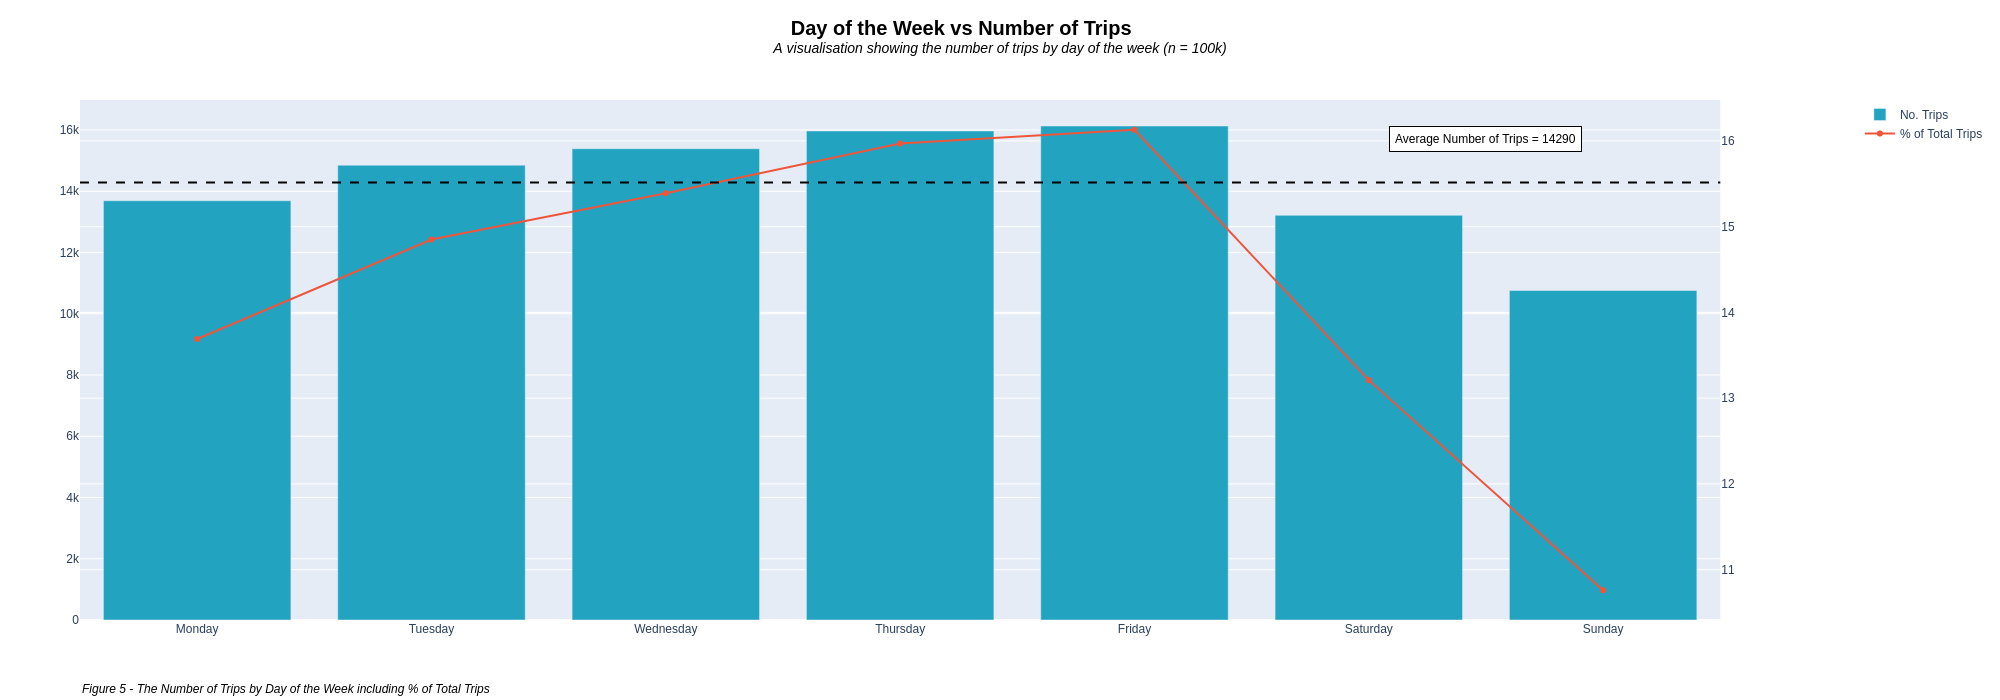

,Day (int),Day,Number of Trips,% of Total Trips
0,0,Monday,13689,13.69
1,1,Tuesday,14851,14.85
2,2,Wednesday,15388,15.39
3,3,Thursday,15969,15.97
4,4,Friday,16131,16.13
5,5,Saturday,13214,13.21
6,6,Sunday,10758,10.76


In [47]:
#@title Day of the Week vs Number of Trips Code
df_weekday = df_random
#Add a column for day of the week (integer) based on the trip start timestamp column
df_weekday['Day (int)'] = df_weekday['trip_start_timestamp'].dt.weekday
#Add a column for day of the week based on the trip start timestamp column
df_weekday['Day'] = df_weekday['trip_start_timestamp'].dt.day_name()
#Groupby the newly added columns, aggregating the number of trips per day based on the unique key column
df_weekday = df_weekday.groupby(['Day (int)','Day']).agg({'unique_key':'nunique'})
#Add a column for % of Total Trips based on the 100k sample size
df_weekday['% of Total Trips'] = 100*df_weekday['unique_key']/df_weekday['unique_key'].sum()
#Format the new column to 2 decimal places
df_weekday = df_weekday.round({'% of Total Trips':2})
#Rename columns for table output
df_weekday = df_weekday.rename(columns={'unique_key':'Number of Trips'})
#Sort columns by day of the week Monday first
df_weekday = df_weekday.sort_values(by=['Day (int)'],ascending=True).reset_index(drop=False)

#variables for the analysis paragraph
thurs = df_weekday['Number of Trips'].iloc[3]
fri = df_weekday['Number of Trips'].iloc[4]

#Create bar chart of number of trips by week day
trace1 = go.Bar(
    x=df_weekday['Day'],
    y=df_weekday['Number of Trips'],
    name = 'No. Trips',
    marker=dict(
        color='rgb(34,163,192)'
               )
)
#Create line chart of the % of Total Trips by Day
trace2 = go.Scatter(
    x=df_weekday['Day'],
    y=df_weekday['% of Total Trips'],
    name='% of Total Trips',
    yaxis='y2'

)
#Combine both charts
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig.update_layout(
    title=dict(
        text='<b>Day of the Week vs Number of Trips</b>\
              <br><i><sup>A visualisation showing the number of trips by day of the week (n = 100k)</sup></i>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Arial",
            size=20,
            color='#000000'
        )))
#Add average number of trips line
fig.add_hline(y=df_weekday['Number of Trips'].mean(),
              line_dash='dash',
              line_color='black')
# Add explanation of line:
fig.add_annotation(x=.75,
                    y=0.95,
                    text="Average Number of Trips = " + str(int(round(df_weekday['Number of Trips'].mean(),-1))),
                    textangle=0,
                    xanchor='left',
                    xref="paper",
                    yref="paper",
                    font_color='black',
                    bordercolor='black',
                    borderpad=5,
                    showarrow=False,
                    bgcolor='white',
                    )
# Add figure annotation:
fig.add_annotation(x=0,
                    y=-0.15,
                    showarrow=False,
                    text="<i>Figure 5 - The Number of Trips by Day of the Week including % of Total Trips</i>",
                    textangle=0,
                    xanchor='left',
                    xref="paper",
                    yref="paper",
                    font_color='#000000')

#Show the combined charts
fig.show()

#Display table
data_table.DataTable(df_weekday, include_index=True)

In [48]:
#@title Analysis
display(Markdown(f"###Figure 5 shows that Wednesday, Thursday and Friday have the highest number of trips in the week, all roughly 16000, or 16% of the total trips. There is a steady rise of number of trips throughout the week until the weekend when the demand dips, with Sunday having the lowest trips by a decent margin."))
display(Markdown(f"###Having taxi availability through the weekdays seems viable, with a focus towards the end of the work week being prioritised."))

###Figure 5 shows that Wednesday, Thursday and Friday have the highest number of trips in the week, all roughly 16000, or 16% of the total trips. There is a steady rise of number of trips throughout the week until the weekend when the demand dips, with Sunday having the lowest trips by a decent margin.

###Having taxi availability through the weekdays seems viable, with a focus towards the end of the work week being prioritised.

### **<h3>Time of Day</h3>**

How does the time of day affect the number of trips?<br><br>
To analyse how the time of day affects the number of trips taken, I will group the trip_start_timestamp column into 12 separate bins. This will equate to two hourly windows to cut the data up into. Next I will aggregate the unique_key column to find the number of trips by two hourly window, as well as creating a column for the percentage of the grand total.

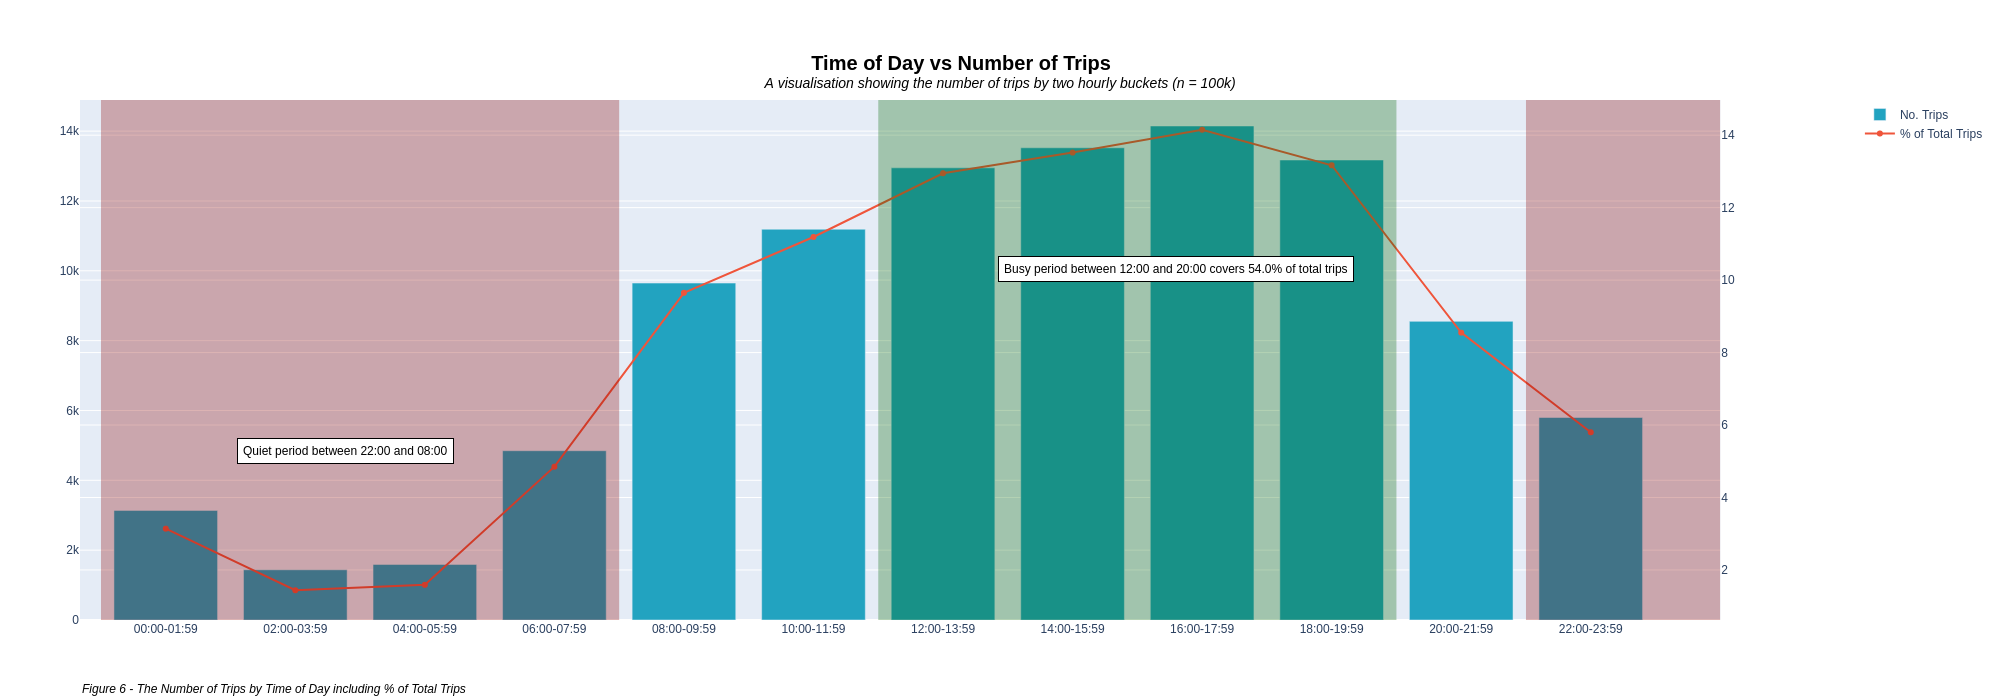

,Time Bin,Number of Trips,Average Fare,% of Total Trips
0,00:00-01:59,3139,20.14,3.14
1,02:00-03:59,1438,17.47,1.44
2,04:00-05:59,1592,26.92,1.59
3,06:00-07:59,4848,21.59,4.85
4,08:00-09:59,9649,18.32,9.65
5,10:00-11:59,11191,19.07,11.19
6,12:00-13:59,12949,19.56,12.95
7,14:00-15:59,13523,19.98,13.52
8,16:00-17:59,14147,18.48,14.15
9,18:00-19:59,13173,18.16,13.17


In [49]:
#@title Time of Day vs Number of Trips Code
df_timeofday = df_random

# define the bins
bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
# add custom labels
labels = ['00:00-01:59', '02:00-03:59', '04:00-05:59', '06:00-07:59', '08:00-09:59', '10:00-11:59', '12:00-13:59', '14:00-15:59', '16:00-17:59', '18:00-19:59', '20:00-21:59', '22:00-23:59']
# add the bins to the dataframe
df_timeofday['Time Bin'] = pd.cut(df_timeofday.trip_start_timestamp.dt.hour, bins, labels=labels, right=False)
#Group by Time Bin column
df_timeofday = df_timeofday.groupby(['Time Bin'],as_index=False).agg({'unique_key':'nunique','fare':'mean'})
#Round the fare and miles formatting to 2 decimal places
df_timeofday = df_timeofday.round({'fare':2})
#Rename columns for table output
df_timeofday = df_timeofday.rename(columns={'unique_key':'Number of Trips','fare':'Average Fare'})
#Add a column for % of Total Trips based on the 100k sample size
df_timeofday['% of Total Trips'] = 100*df_timeofday['Number of Trips']/df_timeofday['Number of Trips'].sum()
#Format the new column to 2 decimal places
df_timeofday = df_timeofday.round({'% of Total Trips':2})
#Variables for analysis
busy_period = df_timeofday.iloc[6]+df_timeofday.iloc[7]+df_timeofday.iloc[8]+df_timeofday.iloc[9]
busy_period = busy_period['% of Total Trips'].round(0)
busiest = df_timeofday[df_timeofday['% of Total Trips']==df_timeofday['% of Total Trips'].max()]
busiest_time = busiest['Time Bin'].iloc[0]
busiest_per = busiest['% of Total Trips'].iloc[0]
#Create bar chart of number of trips by week day
trace1 = go.Bar(
    x=df_timeofday['Time Bin'],
    y=df_timeofday['Number of Trips'],
    name = 'No. Trips',
    marker=dict(
        color='rgb(34,163,192)'
               )
)
#Create line chart of the % of Total Trips by Day
trace2 = go.Scatter(
    x=df_timeofday['Time Bin'],
    y=df_timeofday['% of Total Trips'],
    name='% of Total Trips',
    yaxis='y2'

)
#Combine both charts
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig.update_layout(
    title=dict(
        text='<b>Time of Day vs Number of Trips</b>\
              <br><i><sup>A visualisation showing the number of trips by two hourly buckets (n = 100k)</sup></i>',
        x=0.5,
        y=0.9,
        font=dict(
            family="Arial",
            size=20,
            color='#000000'
        )))
# Add highlight box:
fig.add_vrect(x0="-0.5",
               x1="3.5",
               fillcolor="darkred",
               opacity=0.3,
               line_width=0)
# Add highlight box:
fig.add_vrect(x0="10.5",
               x1="12",
               fillcolor="darkred",
               opacity=0.3,
               line_width=0)
# Add explanation of line:
fig.add_annotation(x=0.09,
                    y=0.3,
                    text="Quiet period between 22:00 and 08:00",
                    textangle=0,
                    xanchor='left',
                    xref="paper",
                    yref="paper",
                    bordercolor='black',
                    borderpad=5,
                    bgcolor='white',
                    font_color='black',
                    showarrow=False,
                    )
# Add highlight box:
fig.add_vrect(x0="5.5",
               x1="9.5",
               fillcolor="darkgreen",
               opacity=0.3,
               line_width=0)
# Add explanation of line:
fig.add_annotation(x=0.73,
                    y=0.7,
                    text="Busy period between 12:00 and 20:00 covers " +str(busy_period)+"% of total trips",
                    textangle=0,
                    xref="paper",
                    yref="paper",
                    bordercolor='black',
                    borderpad=5,
                    bgcolor='white',
                    font_color='black',
                    showarrow=False,
                    )
# Add figure annotation:
fig.add_annotation(x=0,
                    y=-0.15,
                    showarrow=False,
                    text="<i>Figure 6 - The Number of Trips by Time of Day including % of Total Trips</i>",
                    textangle=0,
                    xanchor='left',
                    xref="paper",
                    yref="paper",
                    font_color='#000000')

fig.update_yaxes(automargin=True)
#Show the combined charts
fig.show()

#Display data
df_timeofday

In [50]:
#@title Analysis
display(Markdown(f"###The busiest part of the day starts from 12:00 and peaks at 16:00 to 18:00 before ending at 20:00. This 8 hour window covers {busy_period}% of the total trips with the {busiest_time} timeframe being the busiest at {busiest_per}%. This timeframe should be prioritised, ensuring enough taxis are available to meet the increased demand to maximise taxi trips."))
display(Markdown(f"###The early morning/late night hours are lower in demand with a big drop after 10pm, which doesn't pick up until 8am."))

###The busiest part of the day starts from 12:00 and peaks at 16:00 to 18:00 before ending at 20:00. This 8 hour window covers 54.0% of the total trips with the 16:00-17:59 timeframe being the busiest at 14.15%. This timeframe should be prioritised, ensuring enough taxis are available to meet the increased demand to maximise taxi trips.

###The early morning/late night hours are lower in demand with a big drop after 10pm, which doesn't pick up until 8am.

### **<h3>Trip Duration</h3>**

How does the Duration of a Trip affect the amount of Trips a Taxi Company can do?<br><br>
Similar to the time of day analysis, I will group the trip_duration column into 10 separate bins of 10 minute intervals each. Next I will aggregate the unique_key column to find the number of trips by 10 minute windows.

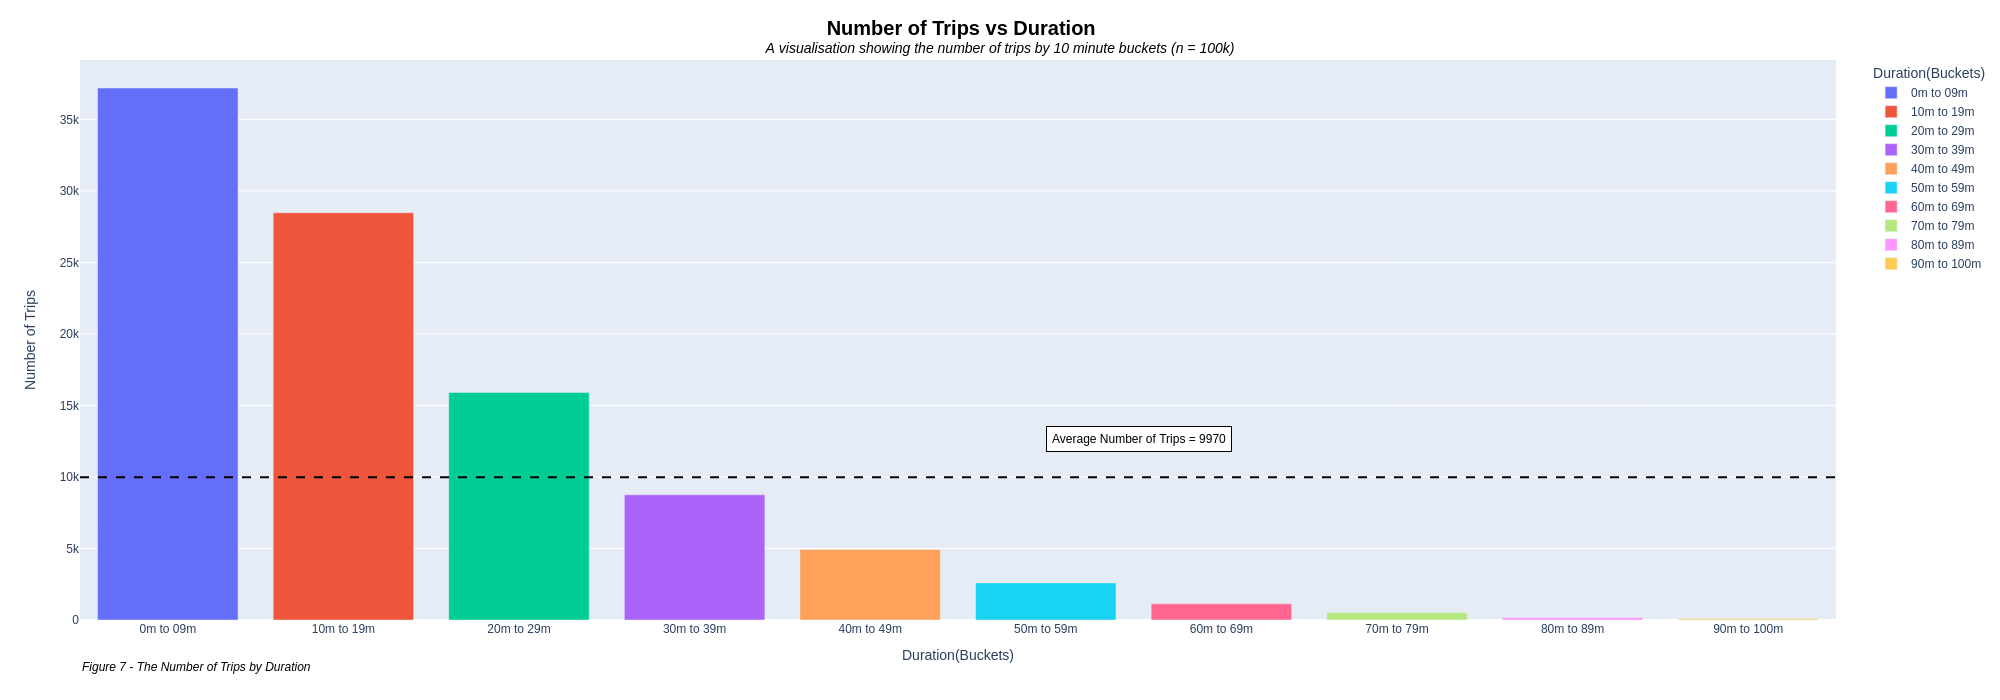

,Duration(Buckets),Number of Trips,% of Total Trips
0,0m to 09m,37196,37.29
1,10m to 19m,28473,28.54
2,20m to 29m,15905,15.95
3,30m to 39m,8754,8.78
4,40m to 49m,4928,4.94
5,50m to 59m,2595,2.60
6,60m to 69m,1128,1.13
7,70m to 79m,518,0.52
8,80m to 89m,171,0.17
9,90m to 100m,80,0.08


In [51]:
#@title Trip Duration Code
df_duration = df_random
# define the bins
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# add custom labels
labels = ['0m to 09m', '10m to 19m', '20m to 29m', '30m to 39m', '40m to 49m', '50m to 59m', '60m to 69m', '70m to 79m', '80m to 89m', '90m to 100m',]
df_duration['trip_minutes'] = df_duration['trip_seconds']/60
# add the bins to the dataframe
df_duration['Duration(Buckets)'] = pd.cut(df_duration.trip_minutes, bins, labels=labels, right=False)
# Group by Time Bin column
df_duration = df_duration.groupby(['Duration(Buckets)'],as_index=False).agg({'unique_key':'nunique'})
#Rename columns for table output
df_duration = df_duration.rename(columns={'unique_key':'Number of Trips'})
#Add a column for % of Total Trips based on the 100k sample size
df_duration['% of Total Trips'] = 100*df_duration['Number of Trips']/df_duration['Number of Trips'].sum()
#Format the new column to 2 decimal places
df_duration = df_duration.round({'% of Total Trips':2})
#Create scatter plot with trendline
fig = px.bar(df_duration,x="Duration(Buckets)",y="Number of Trips", color="Duration(Buckets)",height=700)
fig.update_layout(title=dict(
        text='<b>Number of Trips vs Duration</b>\
              <br><i><sup>A visualisation showing the number of trips by 10 minute buckets (n = 100k)</sup></i>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Arial",
            size=20,
            color='#000000'
        )))
#Add average number of trips line
fig.add_hline(y=df_duration['Number of Trips'].mean(),
              line_dash='dash',
              line_color='black')
# Add explanation of line:
fig.add_annotation(x=.55,
                    y=0.3,
                    text="Average Number of Trips = " + str(int(round(df_duration['Number of Trips'].mean(),-1))),
                    textangle=0,
                    xanchor='left',
                    xref="paper",
                    yref="paper",
                    font_color='black',
                    bordercolor='black',
                    borderpad=5,
                    showarrow=False,
                    bgcolor='white',
                    )
# Add figure annotation:
fig.add_annotation(x=0,
                    y=-0.1,
                    showarrow=False,
                    text="<i>Figure 7 - The Number of Trips by Duration</i>",
                    textangle=0,
                    xanchor='left',
                    xref="paper",
                    yref="paper",
                    font_color='#000000')
#Display scatter plot
fig.show()
#Variables for analysis
dur_top1 = df_duration['% of Total Trips'].iloc[0]
dur_top2 = df_duration['% of Total Trips'].iloc[1]
dur_total = dur_top1 + dur_top2
df_duration

In [52]:
_#@title Analysis
display(Markdown(f"###{dur_top1}% of the trips last up to 10 minutes with a further {dur_top2}% between 10 minutes and 20 minutes equating to a total of {dur_total}%. This would make sense as the shorter the duration of the trip, the more trips the driver can fit in."))
display(Markdown(f"###If the goal is for the company to increase trips, shorter duration trips would be optimal, potentially reducing the focus on Community Area 76 with it's high average distance and duration per trip as previously mentioned."))

###37.29% of the trips last up to 10 minutes with a further 28.54% between 10 minutes and 20 minutes equating to a total of 65.83%. This would make sense as the shorter the duration of the trip, the more trips the driver can fit in.

###If the goal is for the company to increase trips, shorter duration trips would be optimal, potentially reducing the focus on Community Area 76 with it's high average distance and duration per trip as previously mentioned.

## <h2>Summary</h2>

In conclusion, I have analysed the public dataset Chicago Taxi Trips for 2022 and found that if a company wants to increase their total number of taxi trips they should focus on 3 key areas.<br>
Firstly, there is a strong correlation between the number of taxis a company owns and how many trips they provide. This means companies should prioritise increasing their fleet size first and foremost. <br>
Secondly, with an increased fleet size, companies should focus on ensuring availability within Community Areas 8 and 32 between 12pm and 8pm on weekdays, prioritsing shorter duration trips less than 20 minutes long. For this reason less priority should be placed on Community Area 76 as this typically requires longer duration trips.<br>
Thirdly, companies should ensure taxi availability throughout the middle of the year (May to October), with less emphasis placed on the winter months.  


## <h2>Final Comments</h2>

In producing my analysis I have narrowed my scope to answering the question "How can a company increase their total number of taxi trips?", but further consideration could be made towards fare costs and in particular company profits. I have highlighted Community Area 76 as having a high average fare rate (in comparison to the other top 5 Community Areas), however it is unclear based on this data whether that would equate to increased company profits. If, when factoring in fuel costs for higher distance trips and reduced number of trips due to longer individual trip duration, this higher average fare equates to higher profits then Community Area 76 takes higher priority.<br>
It would also be interesting to investigate how weather impacts taxi usage, my analysis shows that there is an increase in taxi usage in the summer months and a decrease during winter, but it would be interesting to cross reference this against specific temperatures. Incorporating a weather api that tracked average temperatures for each date in 2022 would be a good next step.<br>  

Future Updates:
Change figure 3 to show average fare as a whisker plot instead of line chart<br>
Include fare analysis by company?<br> Do companies with lower average fares have increased trip amounts?<br>
Cost by unit (distance or time) by company to see if companies that offer cheaper rates have increased trips. (Obvious drawbacks on profits).<br>
How generalisable is it to non Chicago cities?<br>
Population density of Community Areas to comment on supply and demand within areas?